In [ ]:
import os
import cyvcf2
import msprime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import allel

WORKDIR = "/mnt/qmtang/EvoFill_data/aDNA_simulation_dev"
os.chdir(WORKDIR)

MOD_VCF = "ALL.chr22.phase3.SNPs_only.CHS_CHB.vcf.gz"   # 900 k
ANC_VCF = "aDNA_shimao.chr22.vcf.gz"                    # 16 k

In [2]:
def load_vcf_pos_gt(vcf_path, chrom=None):
    vcf = cyvcf2.VCF(vcf_path)
    n = len(vcf.samples)
    pos, gt_mat = [], []
    for rec in vcf:
        if chrom and rec.CHROM != chrom:
            continue
        pos.append(rec.POS)

        out = np.empty(n, dtype=np.int8)
        for i, gt in enumerate(rec.genotypes):
            a1, a2, _phased = gt
            if a1 == -1 or a2 == -1:
                code = -1
            else:
                code = (1 if a1 > 0 else 0) + (1 if a2 > 0 else 0)
            out[i]=code
        gt_mat.append(out)
    vcf.close()
    return np.array(pos, dtype=np.int32), np.array(gt_mat, dtype=np.int32)
    

In [3]:
anc_pos, anc_gt = load_vcf_pos_gt(ANC_VCF, "22")
print(f"真实古样本：{anc_pos.size} 个位点，{anc_gt.shape[1]} 个个体")
print(np.unique(anc_gt)) 

真实古样本：15802 个位点，147 个个体
[-1  0  1  2]


In [4]:
mod_pos_all, mod_gt_all = load_vcf_pos_gt(MOD_VCF, "22")
print(f"现代样本：{mod_pos_all.size} 个位点，{mod_gt_all.shape[1]} 个个体")
print(np.unique(mod_gt_all)) 

现代样本：1060388 个位点，208 个个体
[0 1 2]


In [5]:
def calc_sfs(gt):
    """
    gt: 整数矩阵 (n_var, n_sample), 缺失=-1
    返回 unfolded SFS（长度 = max_allele_count+1）
    """
    ac_list, nchr_list = [], []
    for row in gt:
        called = row[row >= 0]
        ac     = called.sum()          # ALT 计数
        nchr   = called.size           # 实际染色体条数
        ac_list.append(ac)
        nchr_list.append(nchr)
    # 为了统一 bin 数，取最大染色体条数
    max_nchr = max(nchr_list) if nchr_list else 0
    sfs = np.bincount(ac_list, minlength=max_nchr+1)
    return sfs, nchr_list

def calc_maf(gt: np.ndarray):
    gt = gt.astype(np.int32, copy=False)   # 保证足够宽
    maf = []
    for row in gt:
        called = row[row >= 0]
        ac = int(called.sum())             # 再转 Python int 避免溢出
        nchr = called.size
        if nchr == 0:
            maf.append(np.nan)
        else:
            ac = np.clip(ac, 0, nchr)
            maf.append(min(ac, nchr - ac) / nchr)
    return np.array(maf, dtype=np.float64)

def calc_heterozygosity(gt):
    het_rates = []
    for row in gt:
        called = row[row >= 0]
        n = called.size
        if n == 0:
            het_rates.append(np.nan)
        else:
            hets = (called == 1).sum()
            het_rates.append(hets / n)
    return np.array(het_rates)

def calc_ld(gt, max_dist=200_000, min_calls=20):
    maf = calc_maf(gt)
    keep = (maf > 0.05) & (~np.isnan(maf))
    gt_kept = gt[keep]          # 2-D
    pos = anc_pos[keep]

    # 0/1/2 → 0/0 0/1 1/1
    n_var, n_sam = gt_kept.shape
    g3d = np.empty((n_var, n_sam, 2), dtype=np.int8)
    g3d[:, :, 0] = np.where(gt_kept == 2, 1, 0)          # 第一条染色体
    g3d[:, :, 1] = np.where(gt_kept >= 1, 1, 0)          # 第二条染色体

    g = allel.GenotypeArray(g3d)
    r2, dist = [], []
    for i in range(n_var - 1):
        d = pos[i+1] - pos[i]
        if d > max_dist:
            continue
        gn0 = g[i].to_n_alt()      # 1-D int
        gn1 = g[i+1].to_n_alt()
        sel = (gn0 >= 0) & (gn1 >= 0)
        if sel.sum() < 10:
            continue
        r = np.corrcoef(gn0[sel], gn1[sel])[0, 1]
        r2.append(r**2); dist.append(d)
    return np.array(r2), np.array(dist)


In [6]:
# ---- 基准分布
anc_sfs, anc_nchr_per_site = calc_sfs(anc_gt)
anc_maf = calc_maf(anc_gt)
anc_het = calc_heterozygosity(anc_gt)
anc_r2, anc_d = calc_ld(anc_gt)

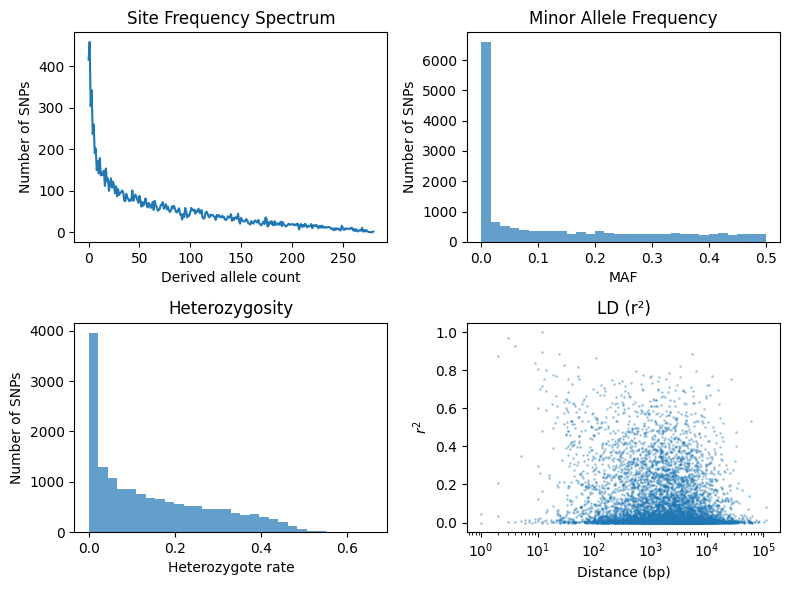

In [7]:
# =========================================================
# Cell-3（修正版）：计算并绘制真实古样本的“基准”分布
# =========================================================

fig, ax = plt.subplots(2, 2, figsize=(8, 6))
# 1) SFS
ax[0, 0].plot(anc_sfs[1:-1])
ax[0, 0].set_title("Site Frequency Spectrum")
ax[0, 0].set_xlabel("Derived allele count")
ax[0, 0].set_ylabel("Number of SNPs")

# 2) MAF
ax[0, 1].hist(anc_maf, bins=30, alpha=.7)
ax[0, 1].set_title("Minor Allele Frequency")
ax[0, 1].set_xlabel("MAF")
ax[0, 1].set_ylabel("Number of SNPs")

# 3) Het
ax[1, 0].hist(anc_het, bins=30, alpha=.7)
ax[1, 0].set_title("Heterozygosity")
ax[1, 0].set_xlabel("Heterozygote rate")
ax[1, 0].set_ylabel("Number of SNPs")

# 4) LD 密度热图
ax[1, 1].scatter(anc_d, anc_r2, s=1, alpha=.3)
ax[1, 1].set_xscale('log')
ax[1, 1].set_xlabel('Distance (bp)')
ax[1, 1].set_ylabel(r'$r^2$')
ax[1, 1].set_title("LD (r²)")
plt.tight_layout()

In [8]:
def subset_mod_to_anc(mod_pos, mod_gt, anc_pos):
    """
    返回与 anc_pos 顺序一致的现代子集
    """
    # 建立 pos→行号 映射
    pos_idx = {p: i for i, p in enumerate(mod_pos)}
    # 按 anc_pos 顺序取行
    keep_rows = [pos_idx[p] for p in anc_pos if p in pos_idx]
    return mod_gt[keep_rows, :]

mod_gt = subset_mod_to_anc(mod_pos_all, mod_gt_all, anc_pos)  # 1.6 k 子集
print(f"过滤后现代样本：{anc_pos.size} 个位点，{mod_gt.shape[1]} 个个体")
mod_pos = anc_pos                                           # 与古代同坐标

过滤后现代样本：15802 个位点，208 个个体


In [9]:
mod_sfs, _ = calc_sfs(mod_gt)
mod_maf = calc_maf(mod_gt)
mod_het = calc_heterozygosity(mod_gt)
mod_r2, mod_d = calc_ld(mod_gt)

In [39]:
mod_sfs, _ = calc_sfs(mod_gt_all)
mod_maf = calc_maf(mod_gt_all)
mod_het = calc_heterozygosity(mod_gt_all)
mod_r2, mod_d = calc_ld(mod_gt_all)

IndexError: boolean index did not match indexed array along axis 0; size of axis is 15802 but size of corresponding boolean axis is 1060388

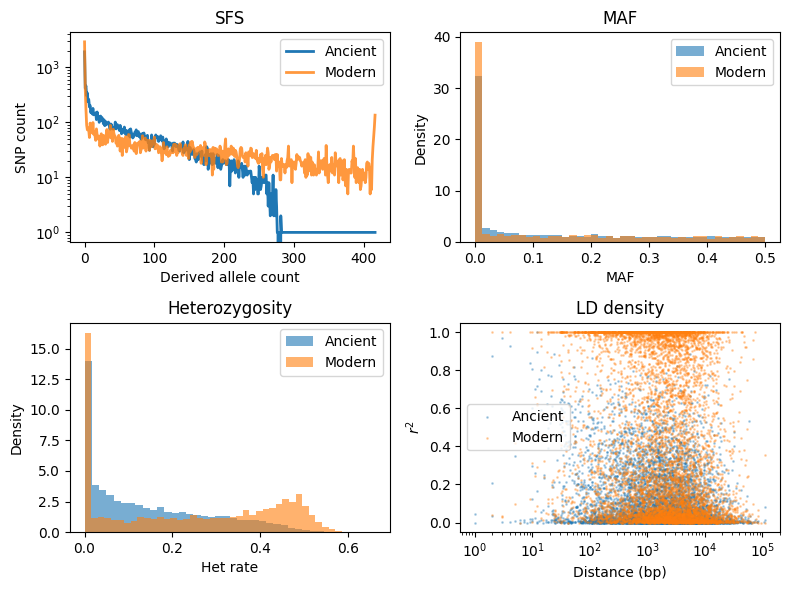

In [10]:
# =========================================================
# Cell-6：现代 vs 古代 分布对比 + 差异指标
# =========================================================

# 4. 画图
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

# SFS
len_common = max(len(anc_sfs), len(mod_sfs))
x = np.arange(len_common)
ax[0,0].plot(x, np.interp(x, np.arange(len(anc_sfs)), anc_sfs), label='Ancient', lw=2)
ax[0,0].plot(x, np.interp(x, np.arange(len(mod_sfs)), mod_sfs), label='Modern', lw=2, alpha=0.8)
ax[0,0].set_yscale('log')
ax[0,0].set_xlabel("Derived allele count"); ax[0,0].set_ylabel("SNP count")
ax[0,0].set_title("SFS"); ax[0,0].legend()

# MAF
ax[0,1].hist(anc_maf, bins=40, alpha=0.6, label='Ancient', density=True)
ax[0,1].hist(mod_maf, bins=40, alpha=0.6, label='Modern', density=True)
ax[0,1].set_xlabel("MAF"); ax[0,1].set_ylabel("Density")
ax[0,1].set_title("MAF"); ax[0,1].legend()

# Het
ax[1,0].hist(anc_het, bins=40, alpha=0.6, label='Ancient', density=True)
ax[1,0].hist(mod_het, bins=40, alpha=0.6, label='Modern', density=True)
ax[1,0].set_xlabel("Het rate"); ax[1,0].set_ylabel("Density")
ax[1,0].set_title("Heterozygosity"); ax[1,0].legend()

# LD 密度
hb1 = ax[1,1].scatter(anc_d, anc_r2, s=1, alpha=.3, label='Ancient',)
hb2 = ax[1,1].scatter(mod_d, mod_r2, s=1, alpha=.3, label='Modern',)
ax[1,1].set_xscale('log')
ax[1,1].set_xlabel('Distance (bp)'); ax[1,1].set_ylabel(r'$r^2$')
ax[1,1].set_title("LD density")
ax[1,1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# =========================================================
# Cell-4：差异统计量函数（EMD 版）
# 统一量纲 0-1，四者平均
# =========================================================
import numpy as np
import ot
from scipy.stats import wasserstein_distance

# ---------- 1. 一维分布差异 ----------
def dist_1d(x, y):
    """Wasserstein-1 / EMD，先插值到同长度"""
    if len(x) != len(y):
        n = max(len(x), len(y))
        x = np.interp(np.linspace(0, 1, n), np.linspace(0, 1, len(x)), x)
        y = np.interp(np.linspace(0, 1, n), np.linspace(0, 1, len(y)), y)
    return wasserstein_distance(x, y)

def dist_hist(x, y, bins=50, range_=None):
    """原始数据 → 概率密度直方图 → EMD"""
    if range_ is None:
        range_ = (min(np.nanmin(x), np.nanmin(y)),
                  max(np.nanmax(x), np.nanmax(y)))
    h1, _ = np.histogram(x, bins=bins, range=range_, density=True)
    h2, _ = np.histogram(y, bins=bins, range=range_, density=True)
    # 概率归一
    h1 /= h1.sum()
    h2 /= h2.sum()
    return dist_1d(h1,h2)

# ---------- 2. LD 二维分布 → 2D-EMD ----------
def dist_ld(d1, r1, d2, r2, nbins=50):
    """(d, r²) 两幅密度图之间的 2D Earth Mover’s Distance"""
    # 统一范围
    d_max = max(d1.max() if d1.size else 1,
                d2.max() if d2.size else 1)
    r_max = 1.0

    # 概率密度矩阵
    H1, xe, ye = np.histogram2d(d1, r1, bins=nbins,
                                range=[[1, d_max], [0, r_max]],
                                density=True)
    H2, _, _  = np.histogram2d(d2, r2, bins=nbins,
                               range=[[1, d_max], [0, r_max]],
                               density=True)
    H1 /= H1.sum()
    H2 /= H2.sum()

    # 地面距离矩阵（网格中心坐标）
    X, Y = np.meshgrid((xe[:-1] + xe[1:]) / 2,
                       (ye[:-1] + ye[1:]) / 2, indexing='ij')
    pos = np.stack([X.ravel(), Y.ravel()], axis=1)
    M = ot.dist(pos, pos, metric='euclidean')
    M /= M.max()                      # 缩放到 0-1

    # 扁平化
    h1 = H1.ravel().astype(np.float64)
    h2 = H2.ravel().astype(np.float64)

    return ot.emd2(h1, h2, M)        # 标量

# ---------- 3. 综合距离 ----------
def combined_emd(gt1, gt2):
    """
    输入：两个 genotype 矩阵 (n_snp, n_ind)，值域 -1/0/1/2
    输出：0-1 区间的综合 EMD 距离
    """
    # 计算四大件
    def stats(gt):
        sfs, _ = calc_sfs(gt)
        return {
            'sfs': sfs,
            'maf': calc_maf(gt),
            'het': calc_heterozygosity(gt),
            'ld_d': calc_ld(gt)[0],
            'ld_r2': calc_ld(gt)[1]
        }

    s1, s2 = stats(gt1), stats(gt2)
    d_sfs = dist_1d(s1['sfs'], s2['sfs'])
    d_maf = dist_hist(s1['maf'], s2['maf'],bins=40, range_=(0,0.5))
    d_het = dist_hist(s1['het'], s2['het'],bins=40, range_=(0,1))
    d_ld = dist_ld(s1['ld_d'], s1['ld_r2'], s2['ld_d'], s2['ld_r2'])
    return (d_sfs + d_maf + d_het + d_ld) / 4

In [41]:
# 5. 计算 EMD 距离
d_sfs = dist_1d(anc_sfs, mod_sfs)
d_maf = dist_hist(anc_maf, mod_maf,bins=40, range_=(0,0.5))
d_het = dist_hist(anc_het, mod_het,bins=40, range_=(0,1))
d_ld  = dist_ld(anc_d, anc_r2, mod_d, mod_r2)
print(f"EMD 距离 — SFS:{d_sfs:.3f}  MAF:{d_maf:.3f}  HET:{d_het:.3f}  LD:{d_ld:.3f}")
print(f"综合距离 = {(d_sfs + d_maf + d_het + d_ld)/4:.3f}")

EMD 距离 — SFS:24.249  MAF:0.004  HET:0.005  LD:0.004
综合距离 = 6.065


In [19]:
import numpy as np
import pandas as pd
import msprime
import tskit
import cyvcf2
from pathlib import Path

# ---------------- 参数 ---------------- #
CHROM = "22"
L_CHR = 51_229_805          # 物理长度 bp
MRATE = 1.25e-8             # 突变率 /bp/gen
GEN_TIME = 29               # 世代时间（年）
TARGET_YEAR = 4000          # 回溯年数
NGEN = int(TARGET_YEAR / GEN_TIME)  # 120 代
REF_PANEL = "genetic_map_GRCh37_chr22.txt"
N_DIPLOID = 208             # 现代个体数
# ------------------------------------- #

def load_genetic_map(path):
    """返回重组率 cM/Mb 的 DataFrame"""
    df = pd.read_csv(path, sep='\s+',)
    df = df.sort_values("Position(bp)")
    df['pos_bp'] = df['Position(bp)'] 
    df["rate"] = df["Rate(cM/Mb)"] * 1e-8   # 转 recombination/bp/gen
    return df

map_df = load_genetic_map(REF_PANEL)
map_df

,Chromosome,Position(bp),Rate(cM/Mb),Map(cM),pos_bp,rate
0,chr22,16051347,8.096992,0.000000,16051347,8.096992e-08
1,chr22,16052618,8.131520,0.010291,16052618,8.131520e-08
2,chr22,16053624,8.131967,0.018472,16053624,8.131967e-08
3,chr22,16053659,8.132625,0.018756,16053659,8.132625e-08
4,chr22,16053758,8.129606,0.019561,16053758,8.129606e-08
...,...,...,...,...,...,...
45324,chr22,51216564,0.644309,74.100959,51216564,6.443090e-09
45325,chr22,51217134,0.643938,74.101326,51217134,6.439380e-09
45326,chr22,51222100,0.648707,74.104524,51222100,6.487070e-09
45327,chr22,51223637,0.655239,74.105521,51223637,6.552390e-09


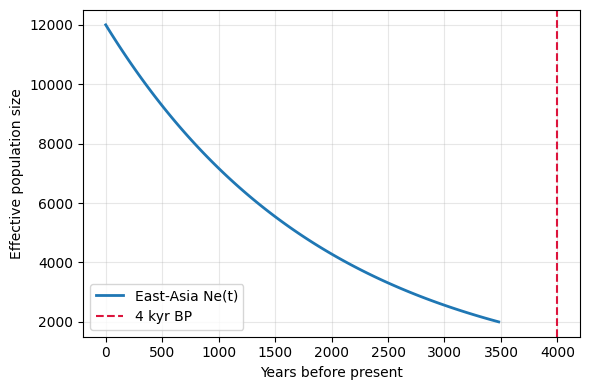

In [41]:
import numpy as np

# 1. 时间网格（generation）
NGEN = 120                 # 4 kyr 反向模拟总世代
gen_time = 29              # 年/世代
gens = np.arange(NGEN + 1)   # 0, 1, ..., 120
years = gens * gen_time      # 0 yr BP, 29 yr BP, ..., 3480 yr BP

# 2. 锚点（generation, Ne）
anchor_gen = np.array([0, 120, 200, 300])
anchor_ne  = np.array([12000, 2000, 1500, 1000])

# 3. log-space 线性插值 → 平滑指数衰减
log_ne = np.interp(gens, anchor_gen, np.log(anchor_ne))
ne_t = np.exp(log_ne)

# 4. 可选：画图验证
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(years, ne_t, lw=2, label='East-Asia Ne(t)')
plt.axvline(4000, ls='--', c='crimson', label='4 kyr BP')
plt.xlabel('Years before present')
plt.ylabel('Effective population size')
plt.grid(alpha=.3)
plt.legend()
plt.tight_layout()
plt.show()

In [53]:
def simulate_ancestors(ne_t, map_df):
    """
    用 msprime 模拟祖先群体
    """
    # 重组图：分段常数重组率
    pos = map_df.pos_bp.values
    rate = map_df.rate.values[:-1]          # 已保证 len(rate)=len(pos)-1

    # ---- 保证第一个 position 是 0 ----
    if pos[0] != 0:
        pos = np.concatenate([[0], pos])
        # 0 到 pos[1] 的重组率可用第一段 rate，或直接用 0
        rate = np.concatenate([[0], rate])

    recomb_map = msprime.RateMap(position=pos, rate=rate)
    # 时间离散化：每代一个 demographic_event
    demography = msprime.Demography()
    demography.add_population(initial_size=ne_t[0])
    for gen in range(1, len(ne_t)):
        demography.add_population_parameters_change(
            time=gen, initial_size=ne_t[gen], population=0
        )
    ts = msprime.sim_ancestry(
        samples=N_DIPLOID * 2,      # 单倍型
        recombination_rate=recomb_map,
        demography=demography,
        sequence_length=L_CHR,
        ploidy=2,
        discrete_genome=True,
        record_migrations=True,
    )
    # 加突变
    ts = msprime.sim_mutations(ts, rate=MRATE*1000, model="binary", discrete_genome=True)
    return ts
    
ts = simulate_ancestors(ne_t, map_df)
ts

In [54]:
sim_pos = ts.tables.sites.position.astype(int)   # 已去重
sim_set = set(sim_pos)
anc_set = set(mod_pos_all)
# 3. 统计 overlap
overlap = anc_set & sim_set
n_anc   = len(anc_set)
n_ov    = len(overlap)

print(f"目标位点数 : {n_anc:,}")
print(f"模拟位点数 : {len(sim_set):,}")
print(f"overlap    : {n_ov:,}  ({n_ov/n_anc*100:.2f}%)")

sim_pos = ts.tables.sites.position.astype(int)   # 已去重
sim_set = set(sim_pos)
anc_set = set(anc_pos)
# 3. 统计 overlap
overlap = anc_set & sim_set
n_anc   = len(anc_set)
n_ov    = len(overlap)

print(f"目标位点数 : {n_anc:,}")
print(f"模拟位点数 : {len(sim_set):,}")
print(f"overlap    : {n_ov:,}  ({n_ov/n_anc*100:.2f}%)")

目标位点数 : 1,060,387
模拟位点数 : 33,343,376
overlap    : 698,540  (65.88%)
目标位点数 : 15,802
模拟位点数 : 33,343,376
overlap    : 10,427  (65.99%)


In [ ]:
# =========================================================
# Cell-6：参数扫描循环
# 不断改变 demography 参数，若差异<阈值则保存
# =========================================================
THRESH = 0.15   # 自己调
results = []

import itertools, json, datetime
N0_grid = [3000, 5000, 7000]
N1_grid = [500, 1000, 1500]
T_grid  = [80, 100, 120]

for N0,N1,T in itertools.product(N0_grid, N1_grid, T_grid):
    ts = run_one_reverse({'N0':N0,'N1':N1,'T':T})
    sim_pos, sim_gt = ts2gt_at_pos(ts, anc_pos)
    sim_sum = summary_stats(sim_pos, sim_gt)
    d = distance_stats(sim_sum)
    if d < THRESH:
        results.append({'N0':N0,'N1':N1,'T':T, 'distance':d,
                        'time':str(datetime.datetime.now())})
print(f"满足阈值参数共 {len(results)} 组")

裁剪后维度: (6970,)


In [ ]:
# =========================================================
# Cell-7：把满足条件的 demography 保存/读取
# =========================================================
import json
with open("fit_demography.json","w") as f:
    json.dump(results, f, indent=2)

# 读取
with open("fit_demography.json") as f:
    loaded = json.load(f)
pd.DataFrame(loaded).sort_values("distance")

PopulationParametersChange(time=110, initial_size=15000, growth_rate=None, population='anc')

In [31]:
ts = msprime.sim_ancestry(
    samples=[msprime.SampleSet(n_anc, ploidy=2, population="anc", time=143),
            msprime.SampleSet(n_mod, ploidy=2, population="mod", time=0)],
    demography=dem,
    sequence_length=recomb_map.sequence_length,   # 显式长度
    recombination_rate=recomb_map, # 直接传 RateMap
    )                


In [32]:
ts = msprime.sim_mutations(ts, rate=MRATE, model="binary")

In [35]:
# 只保留 shimao_sites.bed 位点
sites = pd.read_csv("shimao.sites", sep='\t', header=None)
pos = sites[1].values
keep = np.isin(ts.tables.sites.position, pos)
ts_small = ts.simplify(ts.samples(), filter_sites=False).delete_sites(~keep)
dosage = ts_small.genotype_matrix()          # shape (n_sites, n_samples)
ploidy = 2
gt = allel.GenotypeArray(dosage[..., np.newaxis].repeat(ploidy, axis=2))
ac = gt.count_alleles()
sfs = allel.sfs(ac[:, 1])
maf = np.minimum(ac[:, 0], ac[:, 1]) / ac.sum(axis=1)
ld = allel.rogers_huff_r(gt.to_haplotypes()) ** 2
ss_test = np.concatenate([sfs, maf, ld[np.isfinite(ld)][:1000]])
print('模拟维度:', ss_test.shape)
print('与观测差值的 L2:', np.linalg.norm(ss_test - S_obs_cut))

MemoryError: Unable to allocate 995. GiB for an array with shape (267052955725,) and data type float32

In [21]:
# 2.1 先验
from pyabc import RV
from pyabc.epsilon import ListEpsilon
prior_dict = {
    "N_anc":  RV('loguniform', 1e3, 5e4-1e3),      # 石峁 Ne
    "N_mod":  RV('loguniform', 5e3, 1e5-5e3),      # 现代 EAS Ne
    "T_split":RV('uniform', 100, 200),             # 分裂时间
    "m":      RV('uniform', 0, 1e-3),               # 对称迁移
    "nbott":  RV('loguniform', 5e2, 1e4-5e2),      # 瓶颈大小
    "tbott":  RV('uniform', 50, 130)                # 瓶颈开始
}

def simulate(parameter):
    """一次 ABC 模拟：返回与 S_obs 同维的汇总向量"""
    dem = msprime.Demography()
    dem.add_population(name="anc", initial_size=parameter["N_anc"])
    dem.add_population(name="mod", initial_size=parameter["N_mod"])
    dem.add_symmetric_migration(rate=parameter["m"], populations=["anc","mod"])
    # 瓶颈
    dem.add_population_parameters_change(
        time=parameter["tbott"], initial_size=parameter["nbott"], population="anc")
    dem.add_population_parameters_change(
        time=parameter["tbott"]+20, initial_size=parameter["N_anc"], population="anc")
    # 采样：现代 266 人，古 147 人

    ts = msprime.sim_ancestry(
        samples=[msprime.SampleSet(n_anc, ploidy=2, population="anc", time=143),
                 msprime.SampleSet(n_mod, ploidy=2, population="mod", time=0)],
        demography=dem, sequence_length=L_CHR, recombination_map=recomb_map)
    ts = msprime.sim_mutations(ts, rate=MRATE, model="binary")
    # 只保留 shimao_sites.bed 位点
    sites = pd.read_csv("shimao_sites.bed", sep='\t', header=None)
    pos = sites[1].values
    keep = np.isin(ts.tables.sites.position, pos)
    ts_small = ts.simplify(ts.samples(), filter_sites=False).delete_sites(~keep)
    # 计算同口径统计
    import allel
    gt = allel.GenotypeArray(ts_small.genotype_matrix().T)
    ac = gt.count_alleles()
    sfs = allel.sfs(ac[:,1])
    maf = np.minimum(ac[:,1], ac[:,0]) / ac.sum(axis=1)
    ld  = allel.rogers_huff_r(gt) ** 2
    ss  = np.concatenate([sfs, maf, ld[ld==ld][:1000]])
    return {"ss": ss}

def distance(x, y):
    return np.linalg.norm(x["ss"] - y["ss"])

# 1. 定义阈值策略（这里用 QuantileEpsilon，下限 0.1）
eps = ListEpsilon([0.5, 0.3, 0.2, 0.1])

# 2. 创建 ABCSMC
abc = pyabc.ABCSMC(
        model=simulate,
        parameter=prior_dict,
        distance=pyabc.PNormDistance(p=2),   # 或其他距离
        population_size=1000,
        eps=eps)                             # 关键在这里

# 3. 运行
db_path = pyabc.create_sqlite_db_id()
abc.new(db_path, {"ss": S_obs_cut})
history = abc.run(max_nr_populations=8)      # 不再传 min_epsilon

TypeError: ABCSMC.__init__() got an unexpected keyword argument 'model'

In [ ]:
df, w = history.get_weighted_distances(t=history.max_t)
post_sample = history.get_distribution(m=0, t=history.max_t)[0]
best_par = post_sample.iloc[w.argmin()].to_dict()
print("最佳参数：", best_par)

# 画 marginal
import matplotlib.pyplot as plt
import seaborn as sns
for p in ["N_anc","N_mod","T_split","m"]:
    sns.kdeplot(post_sample[p], shade=True); sns.despine()

In [ ]:
# 4.1 重新建 demography
dem = msprime.Demography()
dem.add_population(name="anc", initial_size=best_par["N_anc"])
dem.add_population(name="mod", initial_size=best_par["N_mod"])
dem.add_symmetric_migration(rate=best_par["m"], populations=["anc","mod"])
# 瓶颈
tb, nb = best_par["tbott"], best_par["nbott"]
dem.add_population_parameters_change(time=tb, initial_size=nb, population="anc")
dem.add_population_parameters_change(time=tb+20, initial_size=best_par["N_anc"], population="anc")

# 4.2 每 3.6 代（≈100 年）采样 100 二倍体
years = np.arange(0, 4100, 100)  # 0-4000
gens  = np.round(years/29).astype(int)
for gen in gens:
    ts_path = f"vcf_per100yr/chr22.t{gen:03d}.vcf"
    os.makedirs("vcf_per100yr", exist_ok=True)
    ts = msprime.sim_ancestry(
        samples=[msprime.SampleSet(100, ploidy=2, population="mod", time=gen)],
        demography=dem, sequence_length=L_CHR, recombination_rate=RRATE,
        random_seed=gen)
    ts = msprime.sim_mutations(ts, rate=MRATE, model="binary")
    with open(ts_path, "w") as f:
        ts.write_vcf(f, contig_id=CHROM)
    !bgzip -f {ts_path}
print("完成！共", len(gens), "个 VCF")

In [ ]:
# 5.1 提取同样 1.6 k 位点
sim_4k = "vcf_per100yr/chr22.t143.vcf.gz"
!bcftools view -R shimao_sites.bed -Oz -o sim4k_over_shim.vcf.gz {sim_4k}

# 5.2 计算两组 SFS/MAF/LD
sim_stats = calc_stats_vcf("sim4k_over_shim.vcf.gz", 100)

fig, ax = plt.subplots(1,3,figsize=(15,4))
ax[0].plot(shim_stats["sfs"], label="Shimao")
ax[0].plot(sim_stats["sfs"],  label="Simulated")
ax[0].set_title("SFS")
ax[1].hist(shim_stats["maf"], alpha=0.5, label="Shimao", bins=20)
ax[1].hist(sim_stats["maf"],  alpha=0.5, label="Simulated", bins=20)
ax[1].set_title("MAF")
ax[2].hist(shim_stats["ld"], alpha=0.5, label="Shimao", bins=50)
ax[2].hist(sim_stats["ld"],  alpha=0.5, label="Simulated", bins=50)
ax[2].set_title("LD r²")
for a in ax: a.legend()
plt.show()